# Regression to the mean with Hits

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [127]:
con = sqlite3.connect("C:\\Users\\posit\\Dropbox\\SQL Databases\\lahmansbaseballdb.sqlite")
df = pd.read_sql("SELECT * FROM batting", con)

In [3]:
df.head()

,ID,playerID,yearID,stint,teamID,team_ID,lgID,G,G_batting,AB,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,1,abercda01,1871,1,TRO,8,NA,1,None,4,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,0.0
1,2,addybo01,1871,1,RC1,7,NA,25,None,118,...,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,0.0
2,3,allisar01,1871,1,CL1,3,NA,29,None,137,...,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,1.0
3,4,allisdo01,1871,1,WS3,9,NA,27,None,133,...,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,0.0
4,5,ansonca01,1871,1,RC1,7,NA,25,None,120,...,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,0.0


In [40]:
len(df['playerID'].unique())

19689

In [66]:
first = []
second = []
for i in df['playerID'].unique():
    temp = df[df['playerID']== i]
    if len(temp) > 2:
        if temp['AB'].iloc[0] >= 130 & temp['AB'].iloc[1] >= 130:
            first.append(temp['H'].iloc[0])
            second.append(temp['H'].iloc[1]) 
        elif temp['AB'].iloc[1] >= 130 & temp['AB'].iloc[2] >= 130:
            first.append(temp['H'].iloc[1])
            second.append(temp['H'].iloc[2])

In [67]:
len(first), len(second)

(1004, 1004)

In [68]:
hits_12 = pd.DataFrame({'first_season': first,'second_season': second})

In [69]:
np.mean(hits_12['first_season'])

85.29780876494024

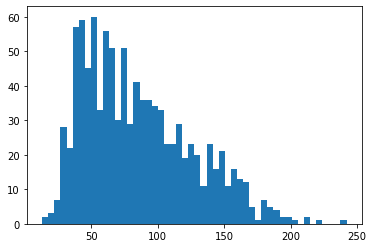

In [70]:
plt.hist(hits_12['first_season'], bins=50)
plt.show()

In [71]:
np.mean(hits_12['second_season'])

86.50298804780877

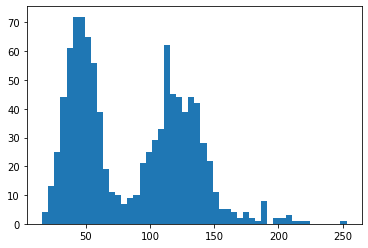

In [72]:
plt.hist(hits_12['second_season'],bins=50)
plt.show()

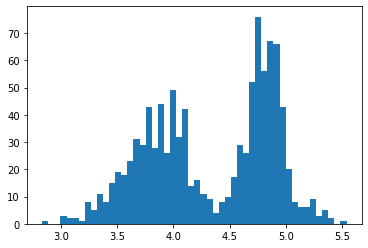

In [73]:
plt.hist(np.log(hits_12['second_season']+1), bins=50)
plt.show()

In [92]:
from scipy import stats

In [74]:
first_bc, lmda = stats.boxcox(hits_12['first_season'])
lmda

0.18760311884648137

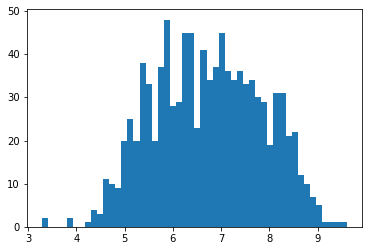

In [75]:
plt.hist(first_bc, bins=50)
plt.show()

In [76]:
second_bc, lmda = stats.boxcox(hits_12['second_season']+1)
lmda

0.276532161068943

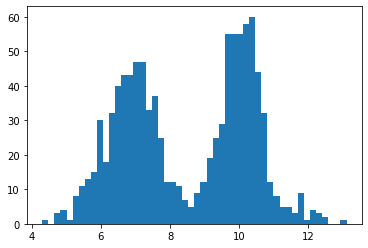

In [77]:
plt.hist(second_bc, bins=50)
plt.show()

In [78]:
stats.ttest_ind(first_bc, second_bc,equal_var=False)

Ttest_indResult(statistic=-26.6215800120429, pvalue=1.467134793553441e-130)

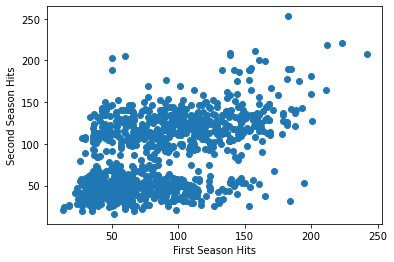

In [79]:
plt.scatter(hits_12['first_season'],hits_12['second_season'])
plt.xlabel('First Season Hits')
plt.ylabel('Second Season Hits')
plt.show()

In [81]:
hits_12['difference'] = hits_12['second_season']-hits_12['first_season']
hits_12.head()

,first_season,second_season,difference
0,90,101,11
1,63,99,36
2,85,75,-10
3,45,53,8
4,54,32,-22


In [82]:
hits_12['z_score']=stats.zscore(hits_12['difference'])
hits_12.head()

,first_season,second_season,difference,z_score
0,90,101,11,0.229621
1,63,99,36,0.815700
2,85,75,-10,-0.262685
3,45,53,8,0.159292
4,54,32,-22,-0.544002


In [83]:
hits = hits_12.loc[hits_12['z_score'].abs()<=3]
len(hits), len(hits_12)

(997, 1004)

In [84]:
import statsmodels.formula.api as smf
m1 = smf.ols('second_season~first_season', hits_12).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          second_season   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     320.8
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           1.88e-62
Time:                        11:39:23   Log-Likelihood:                -5076.8
No. Observations:                1004   AIC:                         1.016e+04
Df Residuals:                    1002   BIC:                         1.017e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       41.6329      2.778     14.987      0.000      36.182      47.084
first_season     0.5260      0.029     17.911      0.000       0.468       0.584
==============================================================================
Omnibus:                       19.244   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.344
Skew:                           0.244   Prob(JB):                     0.000283
Kurtosis:                       2.609   Cond. No.                         219.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

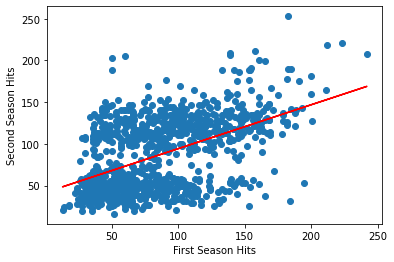

In [89]:
plt.scatter(hits_12['first_season'],hits_12['second_season'])
plt.plot(hits['first_season'], m1.predict(hits['first_season']),c='red')
plt.xlabel('First Season Hits')
plt.ylabel('Second Season Hits')
plt.show()

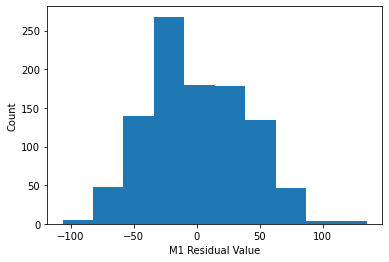

In [91]:
plt.hist(m1.resid)
plt.xlabel('M1 Residual Value')
plt.ylabel('Count')
plt.show()

In [85]:
from statsmodels.graphics import gofplots
from statsmodels.graphics import regressionplots
def plot_gof_figures(model):
    '''Plot a multipanel figure of goodness of fit plots'''
    sns.residplot(model.fittedvalues, model.resid, lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted')
    plt.show()
    _ = gofplots.qqplot(model.resid, fit=True, line='45')
    plt.title('Normal Q-Q')
    plt.show()
    plt.scatter(model.fittedvalues, np.abs(model.resid)**.5)
    plt.xlabel('Fitted values')
    plt.ylabel('Square root of the standardized residuals')
    plt.title('Scale-Location')
    plt.show()
    regressionplots.plot_leverage_resid2(model)

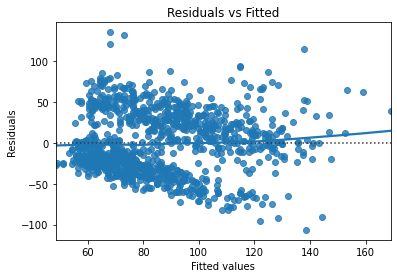

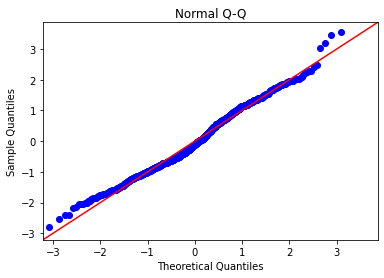

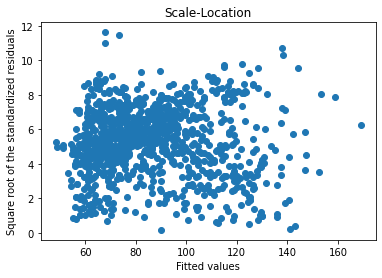

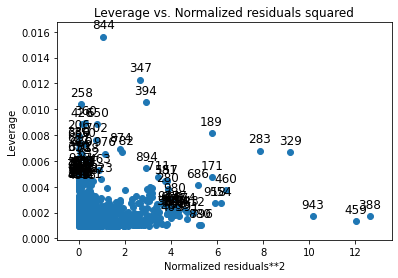

In [85]:
plot_gof_figures(m1)

In [86]:
m2 = smf.ols('second_season~first_season', hits).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          second_season   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     369.0
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           3.46e-70
Time:                        11:40:05   Log-Likelihood:                -5013.4
No. Observations:                 997   AIC:                         1.003e+04
Df Residuals:                     995   BIC:                         1.004e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       39.2122      2.720     14.417      0.000      33.875      44.550
first_season     0.5545      0.029     19.208      0.000       0.498       0.611
==============================================================================
Omnibus:                       50.503   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.421
Skew:                           0.202   Prob(JB):                     3.02e-06
Kurtosis:                       2.330   Cond. No.                         219.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

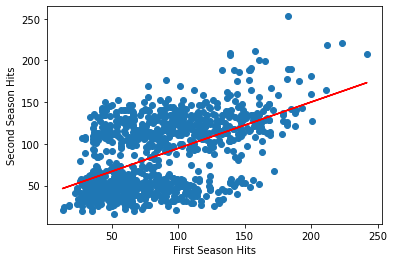

In [90]:
plt.scatter(hits['first_season'],hits['second_season'])
plt.plot(hits['first_season'], m2.predict(hits['first_season']),c='red')
plt.xlabel('First Season Hits')
plt.ylabel('Second Season Hits')
plt.show()

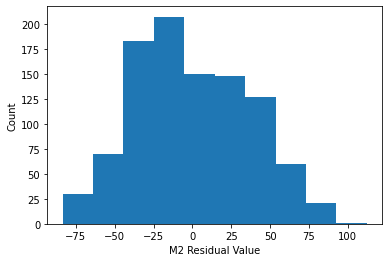

In [92]:
plt.hist(m2.resid)
plt.xlabel('M2 Residual Value')
plt.ylabel('Count')
plt.show()

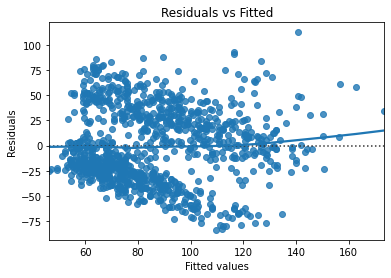

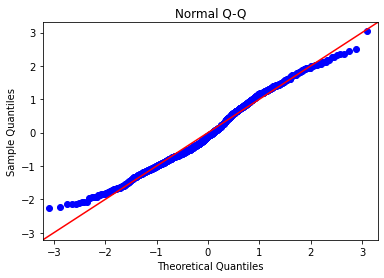

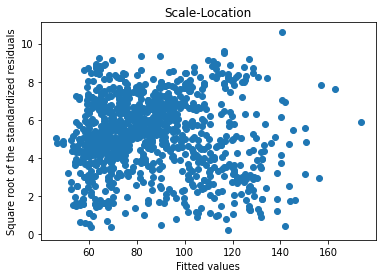

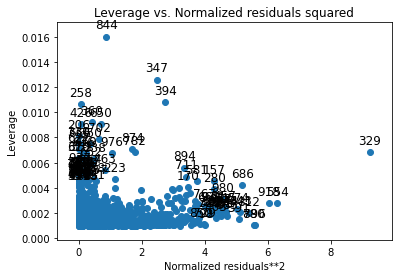

In [93]:
plot_gof_figures(m2)

In [94]:
hits_122 = pd.DataFrame({'first_season': first_bc,'second_season': second_bc})
hits_122.head()

,first_season,second_season
0,7.068463,9.376409
1,6.265962,9.305455
2,6.936219,8.361108
3,5.556587,7.281035
4,5.935408,5.893604


In [95]:
hits_122['difference'] = hits_122['second_season']-hits_122['first_season']
hits_122.head()

,first_season,second_season,difference
0,7.068463,9.376409,2.307946
1,6.265962,9.305455,3.039493
2,6.936219,8.361108,1.424889
3,5.556587,7.281035,1.724448
4,5.935408,5.893604,-0.041804


In [96]:
hits_122['z_score']=stats.zscore(hits_122['difference'])
hits_122.head()

,first_season,second_season,difference,z_score
0,7.068463,9.376409,2.307946,0.330035
1,6.265962,9.305455,3.039493,0.784030
2,6.936219,8.361108,1.424889,-0.217987
3,5.556587,7.281035,1.724448,-0.032082
4,5.935408,5.893604,-0.041804,-1.128212


In [97]:
hits2 = hits_122.loc[hits_122['z_score'].abs()<=2]
len(hits2), len(hits_122)

(969, 1004)

In [99]:
m3 = smf.ols('second_season~first_season', hits_122).fit()
m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          second_season   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     278.4
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           2.43e-55
Time:                        11:44:00   Log-Likelihood:                -1888.2
No. Observations:                1004   AIC:                             3780.
Df Residuals:                    1002   BIC:                             3790.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.4651      0.306     11.322      0.000       2.865       4.066
first_season     0.7489      0.045     16.685      0.000       0.661       0.837
==============================================================================
Omnibus:                       53.527   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.261
Skew:                          -0.157   Prob(JB):                     5.39e-06
Kurtosis:                       2.306   Cond. No.                         42.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

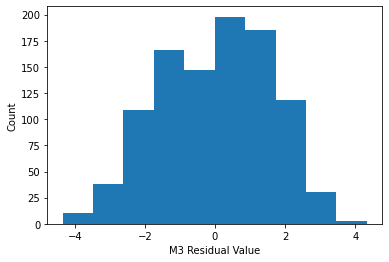

In [100]:
plt.hist(m3.resid)
plt.xlabel('M3 Residual Value')
plt.ylabel('Count')
plt.show()

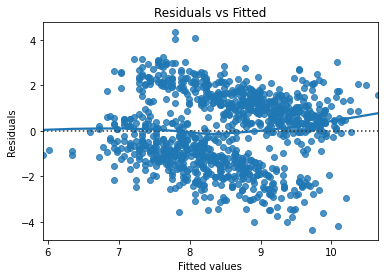

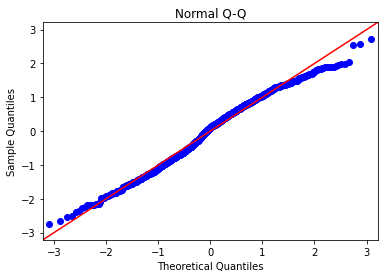

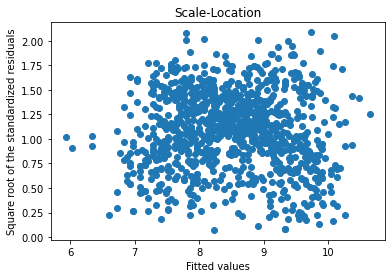

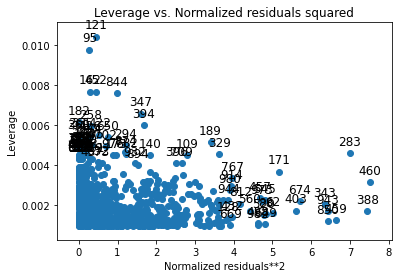

In [101]:
plot_gof_figures(m3)

In [102]:
m4 = smf.ols('second_season~first_season', hits2).fit()
m4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          second_season   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     404.4
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           2.04e-75
Time:                        11:45:58   Log-Likelihood:                -1747.8
No. Observations:                 969   AIC:                             3500.
Df Residuals:                     967   BIC:                             3509.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.7907      0.289      9.648      0.000       2.223       3.358
first_season     0.8536      0.042     20.110      0.000       0.770       0.937
==============================================================================
Omnibus:                       94.211   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.129
Skew:                          -0.112   Prob(JB):                     2.87e-07
Kurtosis:                       2.166   Cond. No.                         42.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

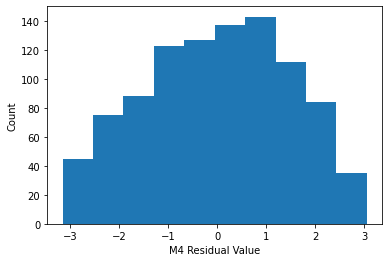

In [103]:
plt.hist(m4.resid)
plt.xlabel('M4 Residual Value')
plt.ylabel('Count')
plt.show()

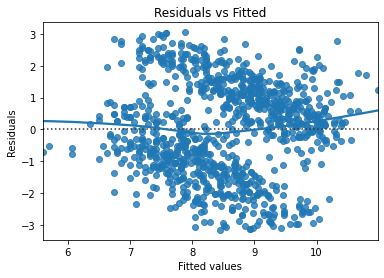

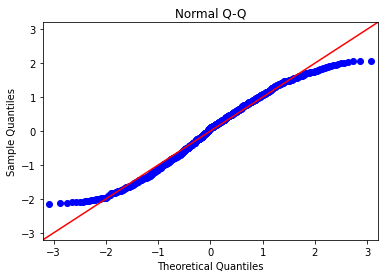

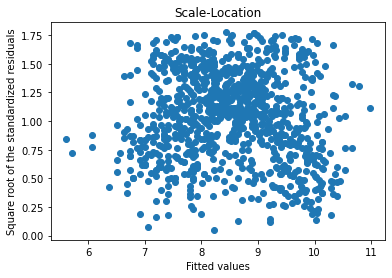

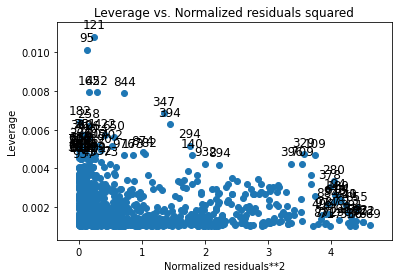

In [104]:
plot_gof_figures(m4)

In [106]:
hits_low = hits_12[hits_12['second_season'] < np.mean(hits_12['second_season'])]
hits_high = hits_12[hits_12['second_season'] >= np.mean(hits_12['second_season'])]

In [107]:
len(hits_low), len(hits_high)

(503, 501)

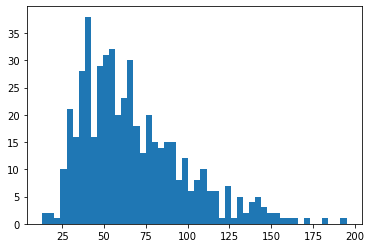

In [108]:
plt.hist(hits_low['first_season'],bins=50)
plt.show()

In [110]:
np.mean(hits_low['first_season'])

67.8727634194831

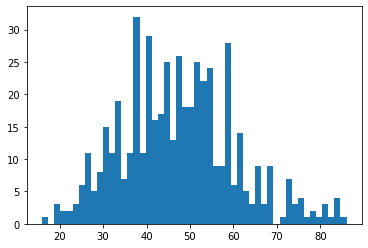

In [111]:
plt.hist(hits_low['second_season'], bins=50)
plt.show()

In [112]:
np.mean(hits_low['second_season'])

47.312127236580515

In [113]:
stats.ttest_ind(hits_low['second_season'], hits_low['first_season'],equal_var=False)

Ttest_indResult(statistic=-13.587331213747243, pvalue=2.517597658188962e-37)

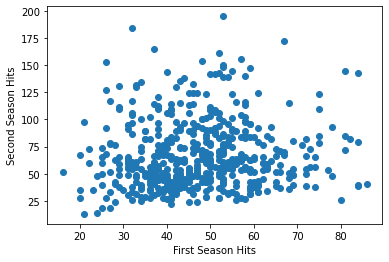

In [114]:
plt.scatter(hits_low['second_season'], hits_low['first_season'])
plt.xlabel('First Season Hits')
plt.ylabel('Second Season Hits')
plt.show()

In [115]:
m5 = smf.ols('second_season~first_season', hits_low).fit()
m5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          second_season   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.907
Date:                Thu, 01 Apr 2021   Prob (F-statistic):             0.0888
Time:                        11:57:24   Log-Likelihood:                -2004.6
No. Observations:                 503   AIC:                             4013.
Df Residuals:                     501   BIC:                             4022.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       45.1611      1.389     32.507      0.000      42.432      47.891
first_season     0.0317      0.019      1.705      0.089      -0.005       0.068
==============================================================================
Omnibus:                       12.776   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.238
Skew:                           0.397   Prob(JB):                      0.00133
Kurtosis:                       3.032   Cond. No.                         179.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

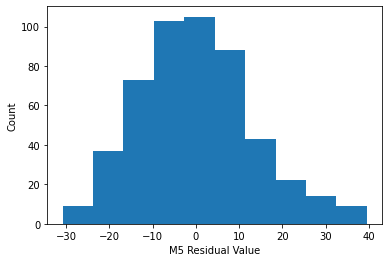

In [116]:
plt.hist(m5.resid)
plt.xlabel('M5 Residual Value')
plt.ylabel('Count')
plt.show()

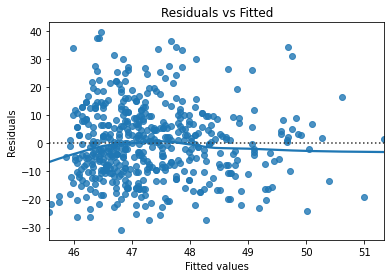

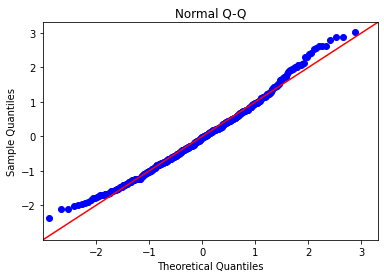

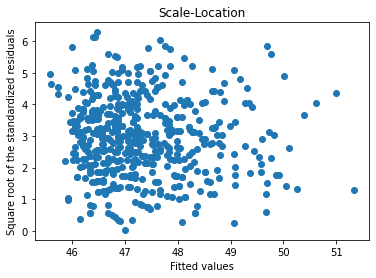

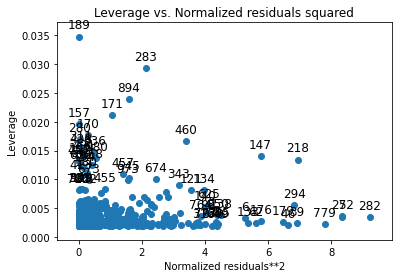

In [117]:
plot_gof_figures(m5)

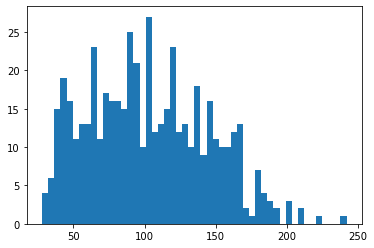

In [118]:
plt.hist(hits_high['first_season'],bins=50)
plt.show()

In [119]:
np.mean(hits_high['first_season'])

102.79241516966069

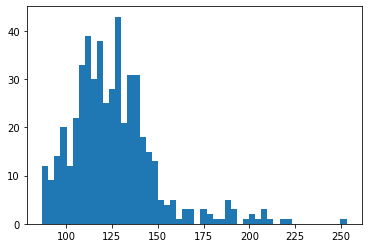

In [120]:
plt.hist(hits_high['second_season'], bins=50)
plt.show()

In [121]:
np.mean(hits_high['second_season'])

125.8502994011976

In [122]:
stats.ttest_ind(hits_high['second_season'], hits_high['first_season'],equal_var=False)

Ttest_indResult(statistic=10.71800003906161, pvalue=4.0624895857533323e-25)

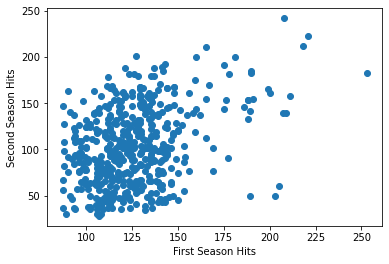

In [123]:
plt.scatter(hits_high['second_season'], hits_high['first_season'])
plt.xlabel('First Season Hits')
plt.ylabel('Second Season Hits')
plt.show()

In [124]:
m6 = smf.ols('second_season~first_season', hits_high).fit()
m6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          second_season   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     74.14
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           9.58e-17
Time:                        12:01:23   Log-Likelihood:                -2261.1
No. Observations:                 501   AIC:                             4526.
Df Residuals:                     499   BIC:                             4535.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      104.9762      2.618     40.100      0.000      99.833     110.120
first_season     0.2031      0.024      8.610      0.000       0.157       0.249
==============================================================================
Omnibus:                      110.140   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              252.180
Skew:                           1.138   Prob(JB):                     1.74e-55
Kurtosis:                       5.627   Cond. No.                         294.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

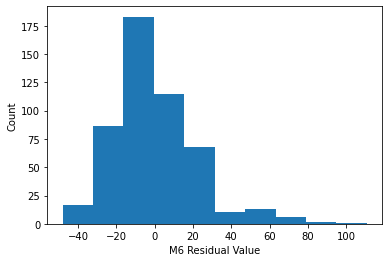

In [125]:
plt.hist(m6.resid)
plt.xlabel('M6 Residual Value')
plt.ylabel('Count')
plt.show()

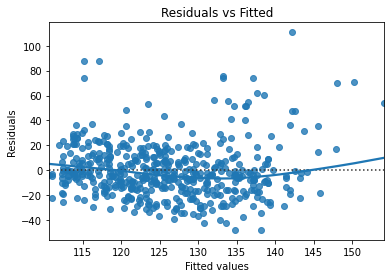

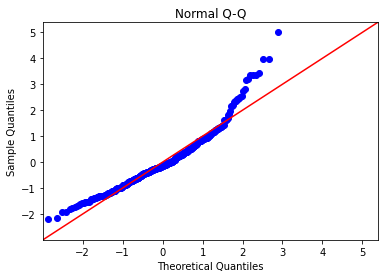

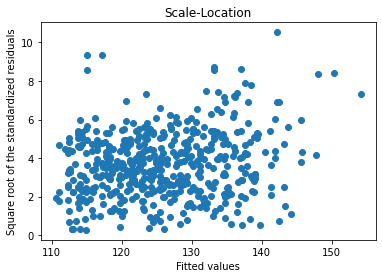

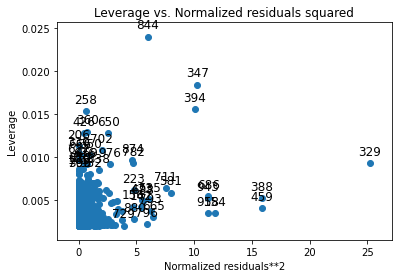

In [126]:
plot_gof_figures(m6)

# Regression to the mean with OPS

In [128]:
df.head()

,ID,playerID,yearID,stint,teamID,team_ID,lgID,G,G_batting,AB,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,1,abercda01,1871,1,TRO,8,NA,1,None,4,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,0.0
1,2,addybo01,1871,1,RC1,7,NA,25,None,118,...,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,0.0
2,3,allisar01,1871,1,CL1,3,NA,29,None,137,...,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,1.0
3,4,allisdo01,1871,1,WS3,9,NA,27,None,133,...,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,0.0
4,5,ansonca01,1871,1,RC1,7,NA,25,None,120,...,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,0.0


In [129]:
df.isna().sum()

ID                0
playerID          0
yearID            0
stint             0
teamID            0
team_ID           0
lgID              0
G                 0
G_batting    107429
AB                0
R                 0
H                 0
2B                0
3B                0
HR                0
RBI             756
SB             2368
CS            23541
BB                0
SO             2100
IBB           36651
HBP            2817
SH             6069
SF            36104
GIDP          25441
dtype: int64

In [130]:
if (df.iloc[:,9] <= 130).any():
    df['SF'].fillna(value=df[df['AB'] <= 130]['SF'].mean().round(), inplace=True)
elif df.iloc[:,9] > 130 & df.iloc[:,9] <=300:
    df['SF'].fillna(value=df[(df['AB'] > 130) & (df['AB'] <=300)]['SF'].mean().round(), inplace=True)
else:
    df['SF'].fillna(value=df[df['AB'] >= 300]['SF'].mean().round(), inplace=True)

In [131]:
if (df.iloc[:,9] <= 130).any():
    df['HBP'].fillna(value=df[df['AB'] <= 130]['HBP'].mean().round(), inplace=True)
elif df.iloc[:,9] > 130 & df.iloc[:,9] <=300:
    df['HBP'].fillna(value=df[(df['AB'] > 130) & (df['AB'] <=300)]['HBP'].mean().round(), inplace=True)
else:
    df['HBP'].fillna(value=df[df['AB'] >= 300]['HBP'].mean().round(), inplace=True)

In [133]:
df['Singles'] = df['H'] - df['2B'] - df['3B'] - df['HR']

In [134]:
df['TB'] = df['Singles'] + (df['2B']*2) + (df['3B']*3) + (df['HR']*4)

In [135]:
df['SLG'] = (df['TB']/df['AB']).round(3)

In [136]:
df['SLG'].fillna(value=0, inplace=True)

In [137]:
df['OBP'] = ((df['H']+df['BB']+df['HBP'])/(df['AB']+df['BB']+df['SF']+df['HBP'])).round(3)

In [138]:
df['OBP'].fillna(value=0, inplace=True)

In [139]:
df['OPS'] = df['OBP']+df['SLG']

In [140]:
first_ops = []
second_ops = []
for i in df['playerID'].unique():
    temp = df[df['playerID']== i]
    if len(temp) > 2:
        if temp['AB'].iloc[0] >= 130 & temp['AB'].iloc[1] >= 130:
            first_ops.append(temp['OPS'].iloc[0])
            second_ops.append(temp['OPS'].iloc[1]) 
        elif temp['AB'].iloc[1] >= 130 & temp['AB'].iloc[2] >= 130:
            first_ops.append(temp['OPS'].iloc[1])
            second_ops.append(temp['OPS'].iloc[2])

In [141]:
len(first_ops), len(second_ops)

(1004, 1004)

In [142]:
ops_12 = pd.DataFrame({'first_season': first_ops,'second_season': second_ops})

In [143]:
np.mean(ops_12['first_season']).round(3)

0.688

In [144]:
np.mean(ops_12['second_season']).round(3)

0.685

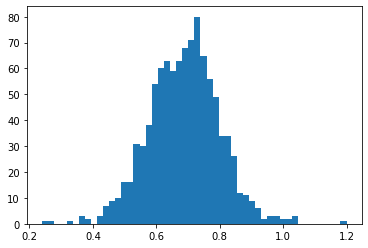

In [145]:
plt.hist(ops_12['first_season'], bins=50)
plt.show()

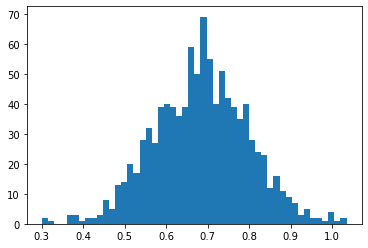

In [146]:
plt.hist(ops_12['second_season'], bins=50)
plt.show()

In [147]:
from scipy import stats

In [148]:
stats.ttest_ind(ops_12['first_season'], ops_12['second_season'],equal_var=False)

Ttest_indResult(statistic=0.6563973064463865, pvalue=0.5116438529309848)

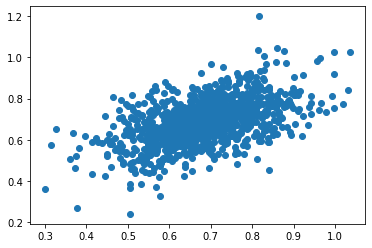

In [149]:
plt.scatter(ops_12['second_season'],ops_12['first_season'])
plt.show()

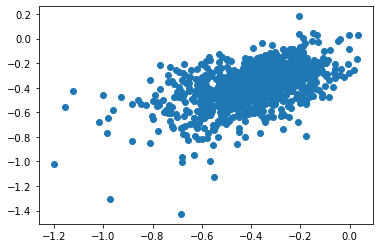

In [150]:
plt.scatter(np.log(ops_12['second_season']),np.log(ops_12['first_season']))
plt.show()

In [155]:
import statsmodels.formula.api as smf
m7 = smf.ols('second_season~first_season', ops_12).fit()
m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          second_season   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     380.7
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           4.12e-72
Time:                        13:09:44   Log-Likelihood:                 916.08
No. Observations:                1004   AIC:                            -1828.
Df Residuals:                    1002   BIC:                            -1818.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.3148      0.019     16.397      0.000       0.277       0.352
first_season     0.5375      0.028     19.511      0.000       0.483       0.592
==============================================================================
Omnibus:                        3.749   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.153   Jarque-Bera (JB):                4.282
Skew:                          -0.026   Prob(JB):                        0.118
Kurtosis:                       3.316   Cond. No.                         13.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

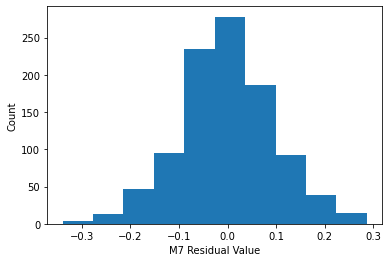

In [156]:
plt.hist(m7.resid)
plt.xlabel('M7 Residual Value')
plt.ylabel('Count')
plt.show()

In [152]:
from statsmodels.graphics import gofplots
from statsmodels.graphics import regressionplots
def plot_gof_figures(model):
    '''Plot a multipanel figure of goodness of fit plots'''
    sns.residplot(model.fittedvalues, model.resid, lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted')
    plt.show()
    _ = gofplots.qqplot(model.resid, fit=True, line='45')
    plt.title('Normal Q-Q')
    plt.show()
    plt.scatter(model.fittedvalues, np.abs(model.resid)**.5)
    plt.xlabel('Fitted values')
    plt.ylabel('Square root of the standardized residuals')
    plt.title('Scale-Location')
    plt.show()
    regressionplots.plot_leverage_resid2(model)

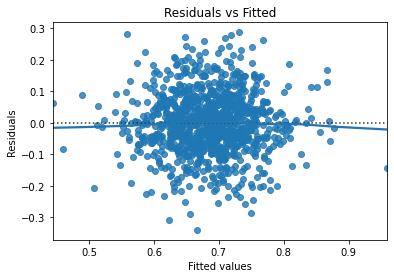

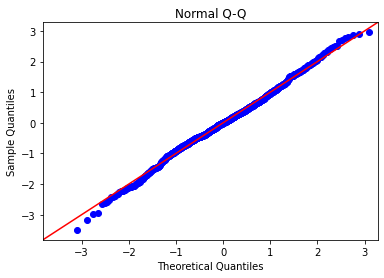

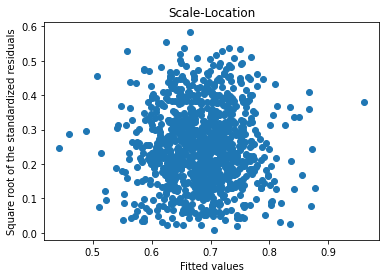

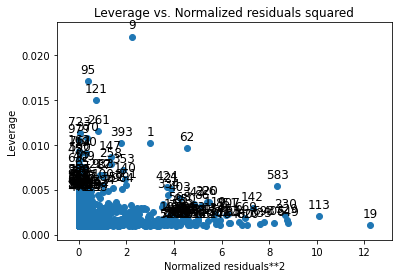

In [157]:
plot_gof_figures(m7)